In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/geojson-for-indian-states/states_india.geojson
/kaggle/input/data-goi/UDISE_2020_21_Table_5.15.csv
/kaggle/input/data-goi/Air_quality_index.csv
/kaggle/input/data-goi/YearWiseCPI_AL_RLofGujarat.csv
/kaggle/input/data-goi/D05-PublicAmenities_11.xls


# <center>=== INDIA AIR QUALITY DATA ANALYSIS === </center>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from folium.plugins import HeatMap
import folium

#  You can get the dataset from this link -> (https://www.data.gov.in/)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)

# Load data
def load_data():
    file_path = '/kaggle/input/data-goi/Air_quality_index.csv'  # Adjust this path
    df = pd.read_csv(file_path)    
    print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# Load the data
df = load_data()
    

Data loaded successfully with 3252 rows and 11 columns


## Preprocessing Data

In [3]:
# Function to preprocess the data
def preprocess_data(df):
    """
    Clean and preprocess the air quality data
    """
    # Display the first few rows to understand the structure
    print("First 5 rows of the raw data:")
    display(df.head())
    
    # Check for concatenated column names (from your example)
    concatenated_cols = [col for col in df.columns if len(col) > 50]
    if concatenated_cols:
        print("Found concatenated column names. Attempting to fix...")
        # This would need specific handling based on your actual column names
    
    # Basic cleaning
    # 1. Strip whitespace from string columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.strip() if hasattr(df[col], 'str') else df[col]
    
    # 2. Convert timestamp to datetime
    if 'last_update' in df.columns:
        print("Converting timestamp to datetime...")
        df['last_update'] = pd.to_datetime(df['last_update'], errors='coerce')
        
        # Extract useful time features
        df['date'] = df['last_update'].dt.date
        df['hour'] = df['last_update'].dt.hour
        df['day_of_week'] = df['last_update'].dt.day_name()
        df['month'] = df['last_update'].dt.month_name()
    
    # 3. Ensure numeric columns are numeric
    numeric_cols = ['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_avg']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 4. Create a pollution level category based on pollutant_avg and type
    # This is a simplified approach - real AQI calculations are more complex
    def categorize_pollution(row):
        pollutant = row.get('pollutant_id', '')
        avg_value = row.get('pollutant_avg', 0)
        
        if pd.isna(pollutant) or pd.isna(avg_value):
            return "Unknown"
        
        # Simplified categorization based on common standards
        if pollutant == 'PM10':
            if avg_value <= 50: return "Good"
            elif avg_value <= 100: return "Moderate"
            elif avg_value <= 250: return "Unhealthy"
            else: return "Hazardous"
        elif pollutant == 'NO2':
            if avg_value <= 40: return "Good"
            elif avg_value <= 80: return "Moderate"
            elif avg_value <= 180: return "Unhealthy"
            else: return "Hazardous"
        elif pollutant == 'CO':
            if avg_value <= 4: return "Good"
            elif avg_value <= 9: return "Moderate"
            elif avg_value <= 15: return "Unhealthy"
            else: return "Hazardous"
        elif pollutant == 'NH3':
            if avg_value <= 200: return "Good"
            elif avg_value <= 400: return "Moderate"
            elif avg_value <= 800: return "Unhealthy"
            else: return "Hazardous"
        else:
            return "Unknown"
    
    # Apply the categorization
    print("Categorizing pollution levels...")
    df['pollution_level'] = df.apply(categorize_pollution, axis=1)
    
    # 5. Handle potential duplicates
    duplicate_count = df.duplicated().sum()
    print(f"Found {duplicate_count} duplicate rows")
    if duplicate_count > 0:
        df = df.drop_duplicates()
    
    # 6. Handle missing values
    missing_values = df.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_values[missing_values > 0])
    
    # Remove rows with missing pollutant data
    rows_before = df.shape[0]
    df = df.dropna(subset=['pollutant_avg'])
    print(f"Removed {rows_before - df.shape[0]} rows with missing pollutant data")
    
    # 7. Summary of preprocessing
    print("\nPreprocessing completed:")
    print(f"- Final dataset shape: {df.shape}")
    print(f"- Number of states: {df['state'].nunique()}")
    print(f"- Number of cities: {df['city'].nunique()}")
    print(f"- Number of stations: {df['station'].nunique()}")
    print(f"- Number of pollutants: {df['pollutant_id'].nunique()}")
    print(f"- Date range: {df['date'].min()} to {df['date'].max()}")
    
    return df

# Preprocess the data
clean_df = preprocess_data(df)
    

First 5 rows of the raw data:


country           state               city  \
0   India  Andhra_Pradesh             Kadapa   
1   India  Andhra_Pradesh  Rajamahendravaram   
2   India  Andhra_Pradesh  Rajamahendravaram   
3   India  Andhra_Pradesh           Tirumala   
4   India  Andhra_Pradesh           Tirumala   

                                             station          last_update  \
0                    Yerramukkapalli, Kadapa - APPCB  08-03-2025 22:00:00   
1     Anand Kala Kshetram, Rajamahendravaram - APPCB  08-03-2025 22:00:00   
2     Anand Kala Kshetram, Rajamahendravaram - APPCB  08-03-2025 22:00:00   
3  Toll Gate, Tirumala - APPCB (Formerly known as...  08-03-2025 22:00:00   
4  Toll Gate, Tirumala - APPCB (Formerly known as...  08-03-2025 22:00:00   

    latitude  longitude pollutant_id  pollutant_min  pollutant_max  \
0  14.465052  78.824187         PM10           73.0          135.0   
1  16.987287  81.736318          NO2           11.0           43.0   
2  16.987287  81.736318           CO           13.0           83.0   
3  13.670000  79.350000          NH3            1.0            2.0   
4  13.670000  79.350000           CO           24.0           48.0   

   pollutant_avg  
0           92.0  
1           24.0  
2           38.0  
3            1.0  
4           36.0

Converting timestamp to datetime...
Categorizing pollution levels...
Found 0 duplicate rows

Missing values in each column:
pollutant_min    183
pollutant_max    183
pollutant_avg    183
dtype: int64
Removed 183 rows with missing pollutant data

Preprocessing completed:
- Final dataset shape: (3069, 16)
- Number of states: 30
- Number of cities: 246
- Number of stations: 482
- Number of pollutants: 7
- Date range: 2025-08-03 to 2025-08-03


## EDA

Performing basic EDA...

Summary statistics for pollutant values:


pollutant_min  pollutant_max  pollutant_avg
count    3069.000000    3069.000000    3069.000000
mean       25.155425      95.235582      52.501466
std        27.310595      98.217183      50.237277
min         1.000000       1.000000       1.000000
25%         6.000000      21.000000      14.000000
50%        14.000000      67.000000      37.000000
75%        36.000000     128.000000      77.000000
max       193.000000     500.000000     370.000000

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


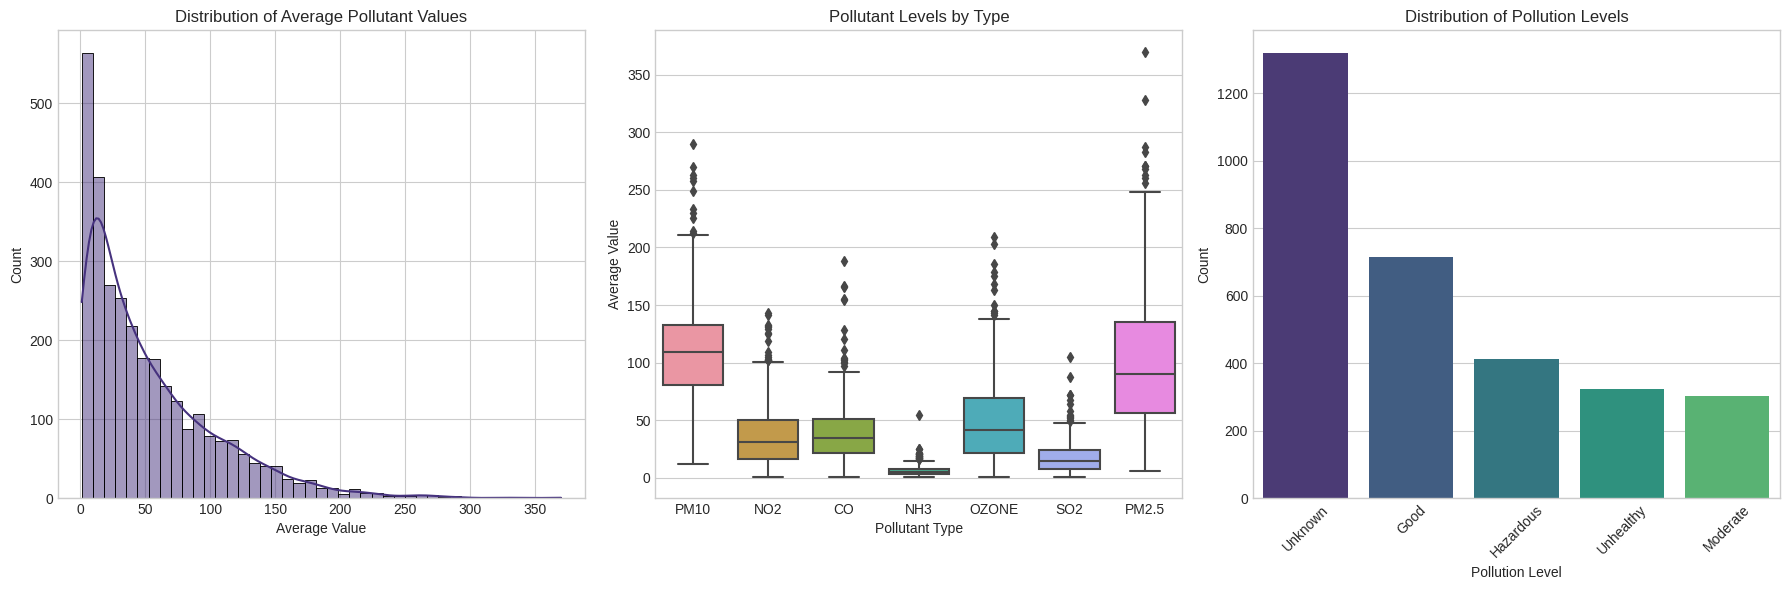


Pollution by State:


state
Delhi               72.700000
Himachal Pradesh    71.285714
Odisha              67.869919
Gujarat             67.311688
Haryana             65.558140
Maharashtra         62.246154
Assam               61.762712
Jharkhand           58.666667
West_Bengal         57.844156
Nagaland            54.285714
Name: pollutant_avg, dtype: float64


Top 10 Most Polluted Cities:


city
Raichur           128.000000
Parbhani          115.571429
Angul             105.142857
Talcher            98.571429
Gurugram           97.133333
Sri Ganganagar     96.571429
Pune               94.327586
Hajipur            93.142857
Nalbari            91.500000
Bileipada          90.400000
Name: pollutant_avg, dtype: float64


Average Levels by Pollutant Type:


pollutant_id
PM10     110.747727
PM2.5    101.546485
OZONE     49.715884
CO        39.730435
NO2       37.377778
SO2       18.138889
NH3        6.167920
Name: pollutant_avg, dtype: float64

In [4]:
# Basic exploratory data analysis
def basic_eda(df):
    """
    Perform basic exploratory data analysis
    """
    print("Performing basic EDA...")
    
    # Summary statistics
    print("\nSummary statistics for pollutant values:")
    display(df[['pollutant_min', 'pollutant_max', 'pollutant_avg']].describe())
    
    # Distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.histplot(df['pollutant_avg'], kde=True, ax=axes[0])
    axes[0].set_title('Distribution of Average Pollutant Values')
    axes[0].set_xlabel('Average Value')
    
    sns.boxplot(x='pollutant_id', y='pollutant_avg', data=df, ax=axes[1])
    axes[1].set_title('Pollutant Levels by Type')
    axes[1].set_xlabel('Pollutant Type')
    axes[1].set_ylabel('Average Value')
    
    pollution_counts = df['pollution_level'].value_counts()
    sns.barplot(x=pollution_counts.index, y=pollution_counts.values, ax=axes[2])
    axes[2].set_title('Distribution of Pollution Levels')
    axes[2].set_xlabel('Pollution Level')
    axes[2].set_ylabel('Count')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # State analysis
    print("\nPollution by State:")
    state_pollution = df.groupby('state')['pollutant_avg'].mean().sort_values(ascending=False)
    display(state_pollution.head(10))
    
    # City analysis
    print("\nTop 10 Most Polluted Cities:")
    city_pollution = df.groupby('city')['pollutant_avg'].mean().sort_values(ascending=False)
    display(city_pollution.head(10))
    
    # Pollutant comparison
    print("\nAverage Levels by Pollutant Type:")
    pollutant_avg = df.groupby('pollutant_id')['pollutant_avg'].mean().sort_values(ascending=False)
    display(pollutant_avg)
    
    return

# Basic EDA
basic_eda(clean_df)
    

## Trends

Analyzing data by pollutant type...

=== Analysis for PM10 ===
Number of measurements: 440
Average value: 110.75
Maximum value: 290.00

Top 5 states with highest PM10 levels:


state
Odisha     145.500000
Delhi      142.236842
Assam      140.250000
Bihar      135.296296
Gujarat    133.300000
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for PM10:


pollution_level
Unhealthy    55.681818
Moderate     37.727273
Good          5.454545
Hazardous     1.136364
Name: proportion, dtype: float64

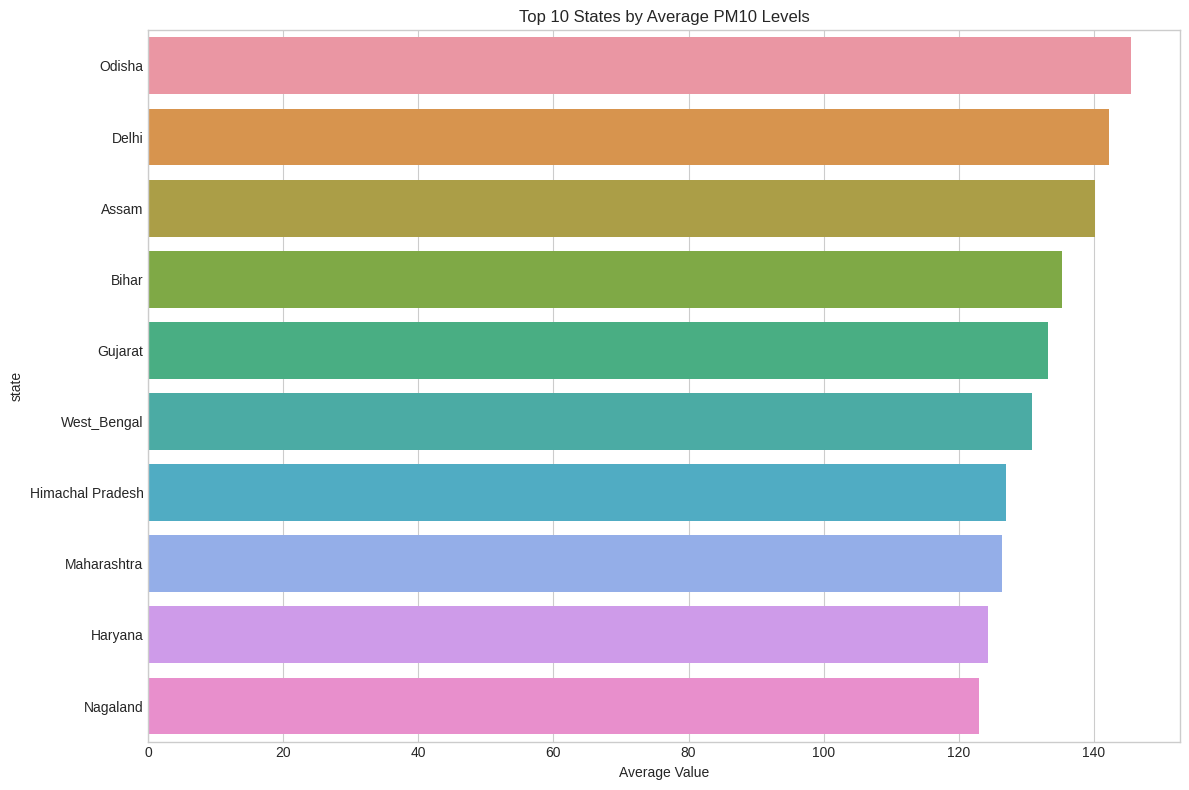


=== Analysis for NO2 ===
Number of measurements: 450
Average value: 37.38
Maximum value: 143.00

Top 5 states with highest NO2 levels:


state
Jharkhand      125.000000
Delhi           67.315789
Gujarat         59.700000
Maharashtra     47.128205
Meghalaya       45.000000
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for NO2:


pollution_level
Good         63.555556
Moderate     27.555556
Unhealthy     8.888889
Name: proportion, dtype: float64

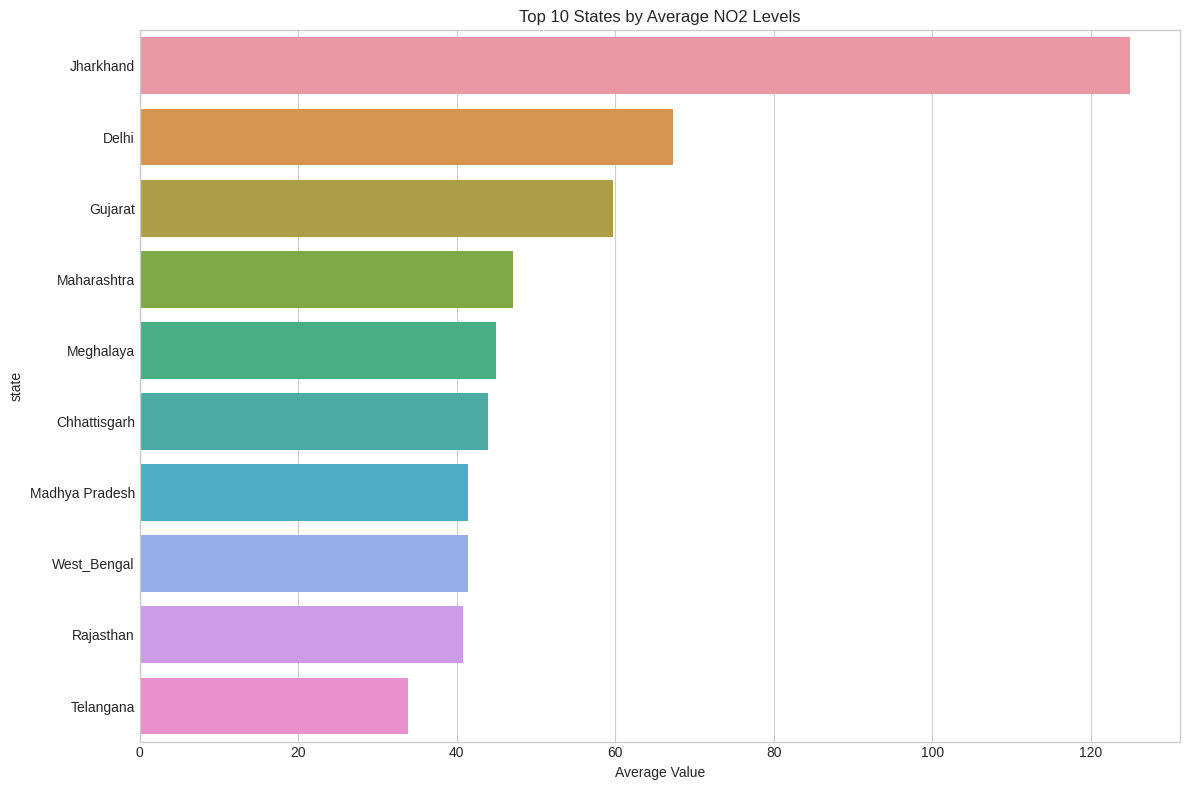


=== Analysis for CO ===
Number of measurements: 460
Average value: 39.73
Maximum value: 188.00

Top 5 states with highest CO levels:


state
Gujarat             56.230769
Himachal Pradesh    55.000000
Punjab              53.714286
Delhi               52.405405
Haryana             51.000000
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for CO:


pollution_level
Hazardous    88.260870
Unhealthy     8.043478
Moderate      2.826087
Good          0.869565
Name: proportion, dtype: float64

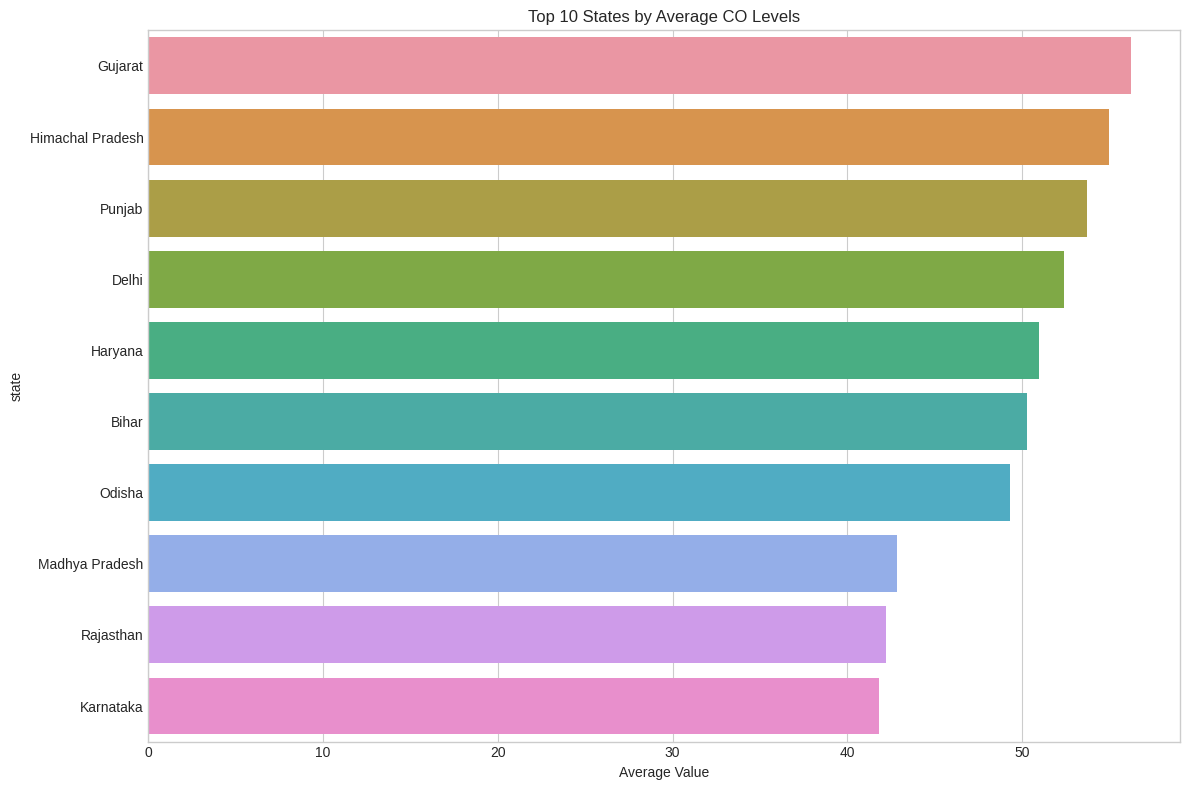


=== Analysis for NH3 ===
Number of measurements: 399
Average value: 6.17
Maximum value: 55.00

Top 5 states with highest NH3 levels:


state
Haryana       16.666667
Chandigarh    13.333333
Meghalaya     12.000000
Rajasthan      8.863636
Delhi          8.741935
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for NH3:


pollution_level
Good    100.0
Name: proportion, dtype: float64

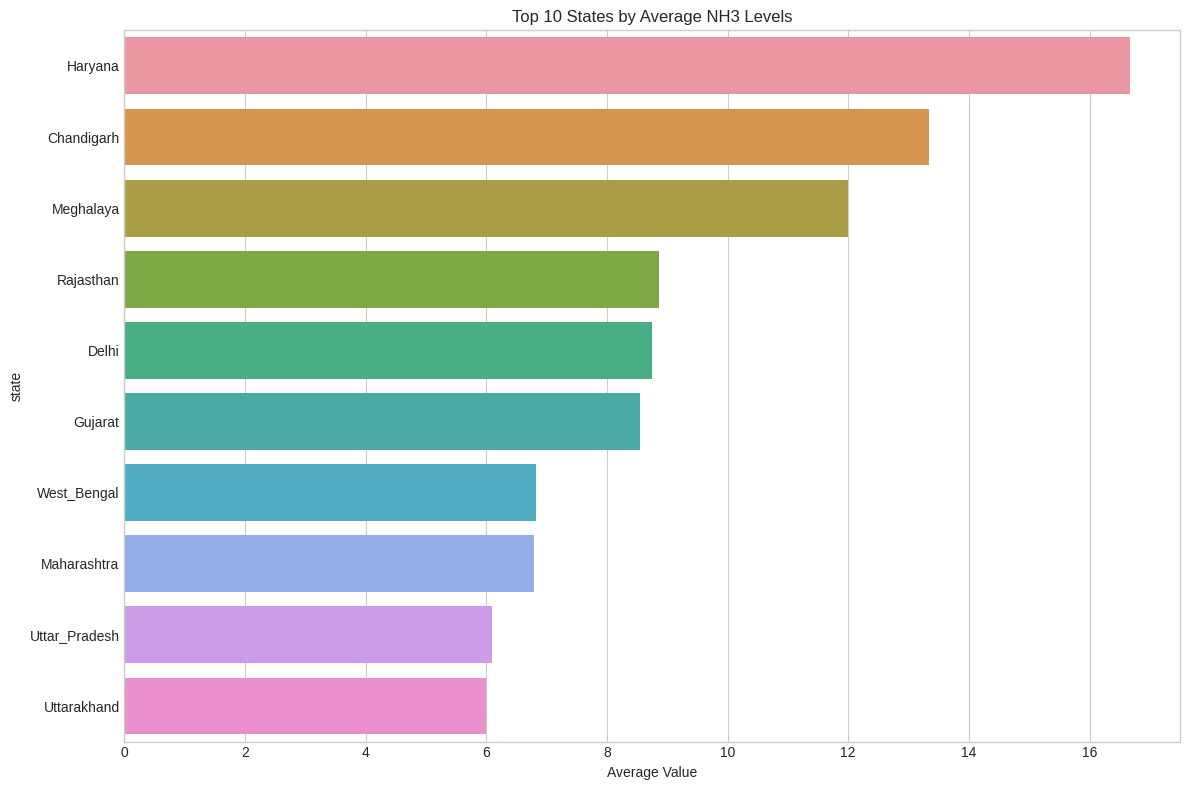


=== Analysis for OZONE ===
Number of measurements: 447
Average value: 49.72
Maximum value: 209.00

Top 5 states with highest OZONE levels:


state
Himachal Pradesh    114.000000
Chandigarh           91.000000
Maharashtra          75.670886
Odisha               67.235294
Rajasthan            64.978261
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for OZONE:


pollution_level
Unknown    100.0
Name: proportion, dtype: float64

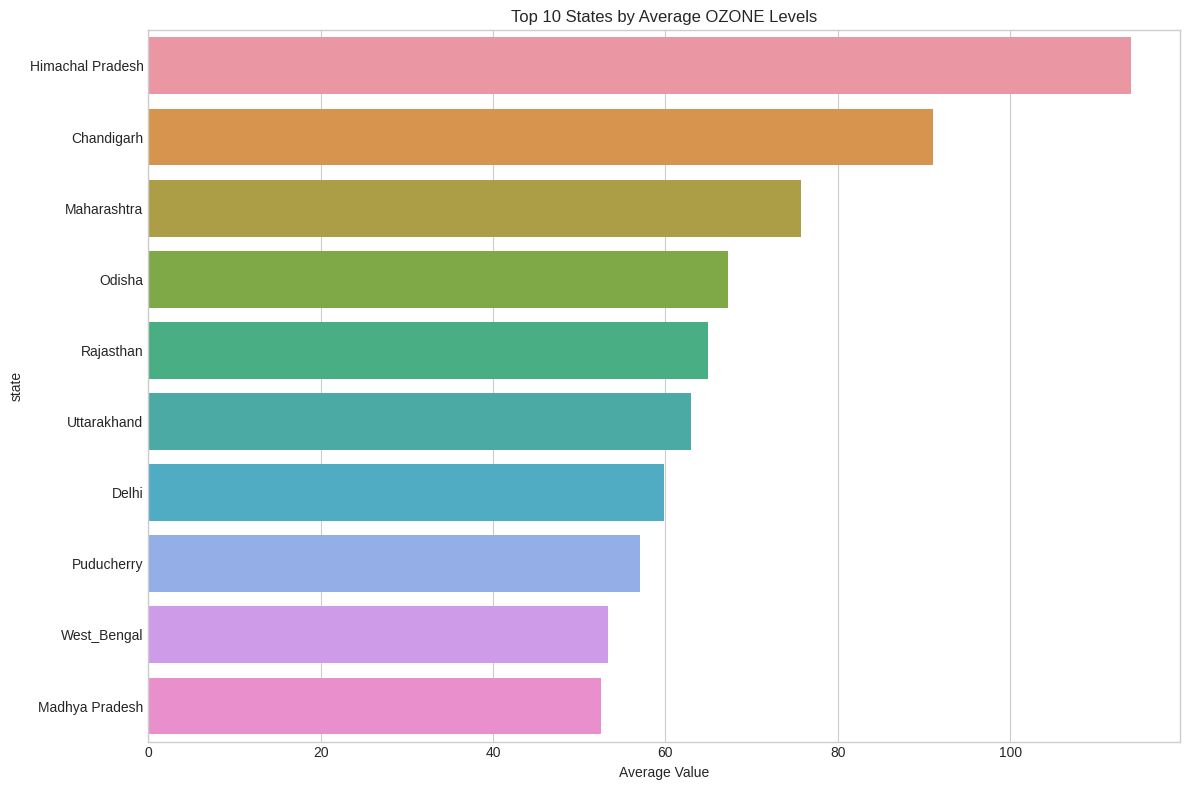


=== Analysis for SO2 ===
Number of measurements: 432
Average value: 18.14
Maximum value: 105.00

Top 5 states with highest SO2 levels:


state
Manipur             105.000000
Nagaland             58.000000
Gujarat              36.818182
Himachal Pradesh     29.000000
Jharkhand            28.000000
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for SO2:


pollution_level
Unknown    100.0
Name: proportion, dtype: float64

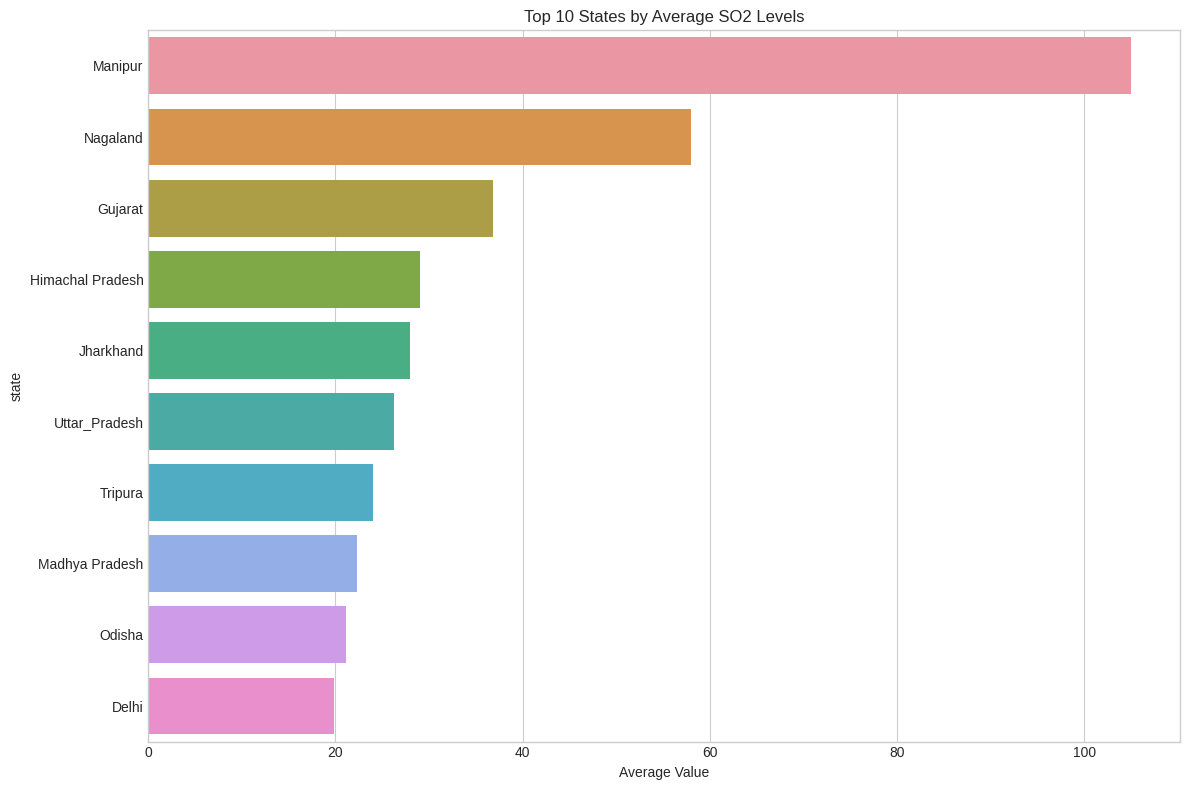


=== Analysis for PM2.5 ===
Number of measurements: 441
Average value: 101.55
Maximum value: 370.00

Top 5 states with highest PM2.5 levels:


state
Assam               175.666667
Himachal Pradesh    156.000000
Nagaland            152.000000
Odisha              146.611111
Haryana             145.428571
Name: pollutant_avg, dtype: float64


Distribution of pollution levels for PM2.5:


pollution_level
Unknown    100.0
Name: proportion, dtype: float64

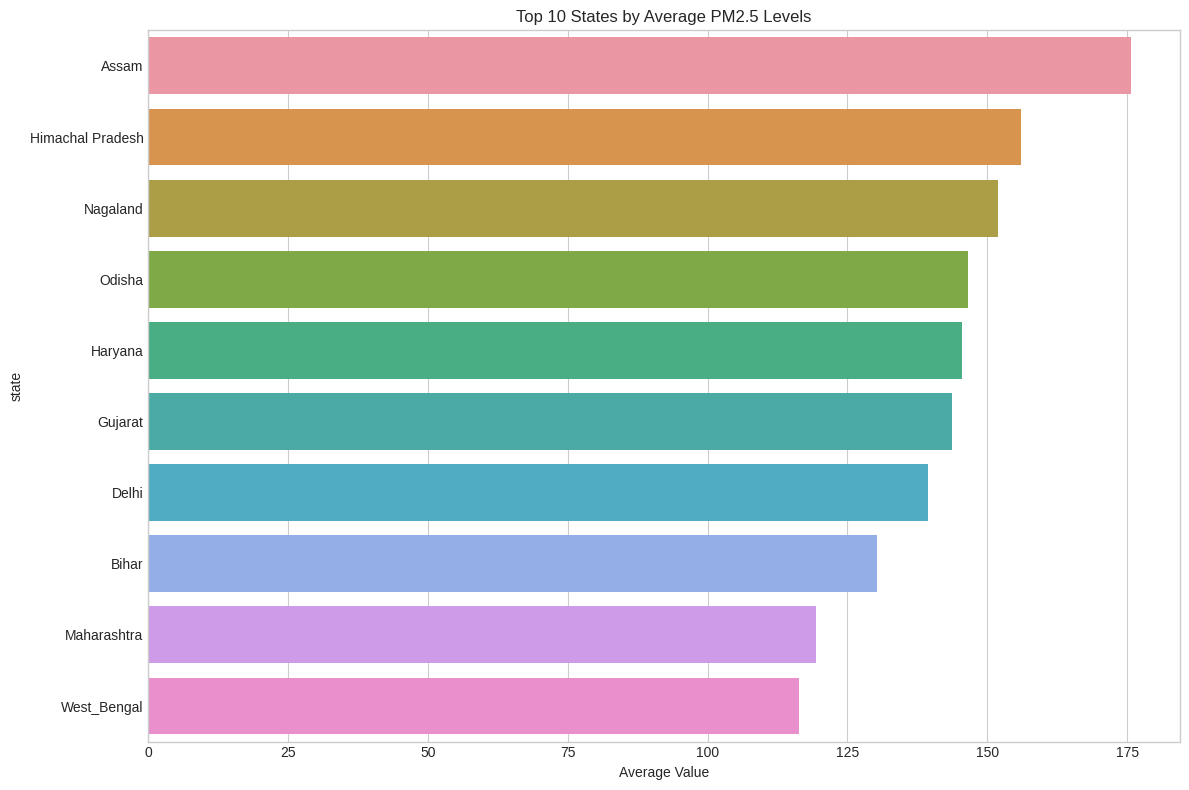

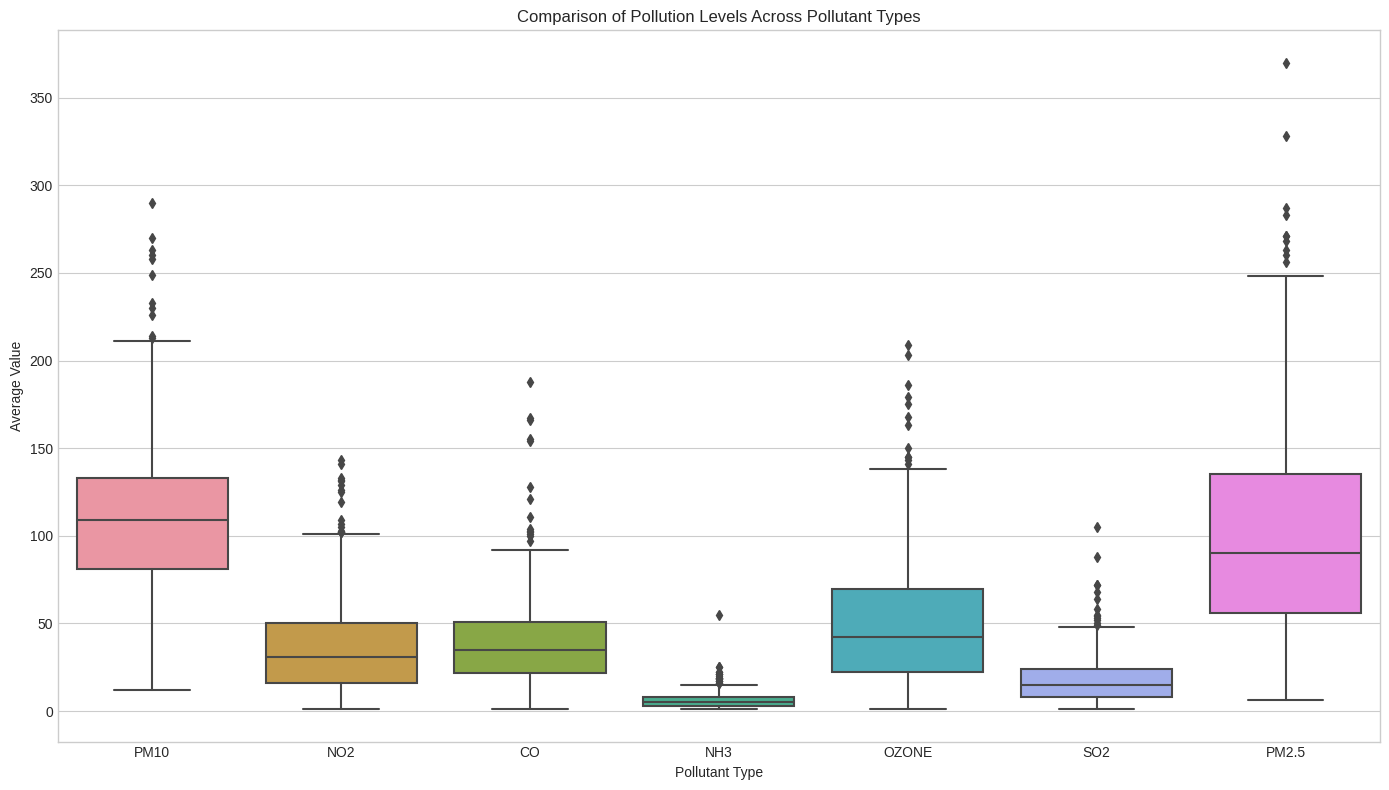

In [5]:
# Analysis by pollutant type
def analyze_by_pollutant(df):
    """
    Analyze pollution data by pollutant type
    """
    print("Analyzing data by pollutant type...")
    
    # Create subplots for each pollutant
    pollutants = df['pollutant_id'].unique()
    
    for pollutant in pollutants:
        pollutant_df = df[df['pollutant_id'] == pollutant]
        
        print(f"\n=== Analysis for {pollutant} ===")
        print(f"Number of measurements: {pollutant_df.shape[0]}")
        print(f"Average value: {pollutant_df['pollutant_avg'].mean():.2f}")
        print(f"Maximum value: {pollutant_df['pollutant_avg'].max():.2f}")
        
        # Top 5 states for this pollutant
        state_levels = pollutant_df.groupby('state')['pollutant_avg'].mean().sort_values(ascending=False)
        print(f"\nTop 5 states with highest {pollutant} levels:")
        display(state_levels.head(5))
        
        # Distribution by category
        pollution_level_counts = pollutant_df['pollution_level'].value_counts(normalize=True) * 100
        print(f"\nDistribution of pollution levels for {pollutant}:")
        display(pollution_level_counts)
        
        # Plot state distribution
        plt.figure(figsize=(12, 8))
        top_states = state_levels.head(10)
        sns.barplot(x=top_states.values, y=top_states.index)
        plt.title(f'Top 10 States by Average {pollutant} Levels')
        plt.xlabel('Average Value')
        plt.tight_layout()
        plt.show()
    
    # Compare all pollutants on a single plot
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='pollutant_id', y='pollutant_avg', data=df)
    plt.title('Comparison of Pollution Levels Across Pollutant Types')
    plt.xlabel('Pollutant Type')
    plt.ylabel('Average Value')
    plt.tight_layout()
    plt.show()
    
    return

# Analyze by pollutant type
analyze_by_pollutant(clean_df)
    

### You can download the pollution_map.html to see the visualization on map of India

## Geographical Analysis

In [6]:
# Geographical analysis
def geographical_analysis(df):
    """
    Analyze pollution data geographically using maps
    """
    print("Performing geographical analysis...")
    
    # Check if we have enough geographical data
    if df['latitude'].isna().sum() > 0.5 * len(df) or df['longitude'].isna().sum() > 0.5 * len(df):
        print("Insufficient geographical data for mapping.")
        return
    
    # Calculate average pollution by station
    station_avg = df.groupby(['station', 'latitude', 'longitude', 'pollutant_id'])['pollutant_avg'].mean().reset_index()
    
    # Create map for overall pollution
    m = folium.Map(location=[20.5937, 78.9629], zoom_start=5, tiles="OpenStreetMap")
    
    # Add markers for each station
    for idx, row in station_avg.iterrows():
        if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
            # Determine color based on pollution level
            if row['pollutant_avg'] < 50:
                color = 'green'
            elif row['pollutant_avg'] < 100:
                color = 'blue'
            elif row['pollutant_avg'] < 150:
                color = 'orange'
            else:
                color = 'red'
            
            # Create popup content
            popup_content = f"""
            <b>Station:</b> {row['station']}<br>
            <b>Pollutant:</b> {row['pollutant_id']}<br>
            <b>Average Level:</b> {row['pollutant_avg']:.2f}
            """
            
            # Add marker to map
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7,
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(m)
    
    # Display the map in Kaggle notebook
    display(m)
    
    # Save map for Kaggle
    m.save("pollution_map.html")
    print("Pollution map saved as 'pollution_map.html'. Download to view.")
    
    return
    
# Geographical analysis
geographical_analysis(clean_df)
    

Performing geographical analysis...


Pollution map saved as 'pollution_map.html'. Download to view.


## Interactive Plots

### The code below creates an interactive plot which may not be visible when you see this notebook.
### To see the plot , you need to run the code block below or download the interactive_plot.html file.

In [7]:
# Interactive visualizations with Plotly
def create_interactive_plots(df):
    """
    Create interactive visualizations using Plotly
    """
    print("Creating interactive visualizations...")
    
    # 1. Interactive state comparison
    state_data = df.groupby(['state', 'pollutant_id'])['pollutant_avg'].mean().reset_index()
    
    fig = px.bar(
        state_data,
        x='state',
        y='pollutant_avg',
        color='pollutant_id',
        barmode='group',
        title='Average Pollution Levels by State and Pollutant Type',
        labels={'pollutant_avg': 'Average Level', 'state': 'State', 'pollutant_id': 'Pollutant Type'}
    )
    
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()
    
    # Save as HTML
    fig.write_html("interactive_plot_bar.html")
    print("Pollution histogram  saved as 'interactive_plot_bar.html'. Download to view.")
    
    # 2. Interactive correlation analysis
    # Pivot the data to get pollutants as columns
    pivot_cols = ['state', 'city', 'station']
    if 'date' in df.columns:
        pivot_cols.append('date')
    
    pivot_df = df.pivot_table(
        index=pivot_cols,
        columns='pollutant_id',
        values='pollutant_avg'
    ).reset_index()
    
    # Calculate correlation between pollutants if we have multiple types
    if len(df['pollutant_id'].unique()) > 1:
        corr_df = pivot_df.select_dtypes(include=[np.number]).corr()
        
        fig = px.imshow(
            corr_df,
            text_auto=True,
            aspect="auto",
            title='Correlation Between Different Pollutants',
            color_continuous_scale='RdBu_r',
            zmin=-1, zmax=1
        )
        
        fig.show()
        
        # Save as HTML
        fig.write_html("interactive_plot_corr.html")
        print("Pollution correlation matrix saved as 'interactive_plot_corr.html'. Download to view.")
    return

# Interactive visualizations
create_interactive_plots(clean_df)
    

Creating interactive visualizations...


Pollution histogram  saved as 'interactive_plot_bar.html'. Download to view.


Pollution correlation matrix saved as 'interactive_plot_corr.html'. Download to view.


## Data Insights

In [8]:
# Generate insights
def generate_insights(df):
    """
    Generate key insights from the air quality data
    """
    print("\n=== KEY INSIGHTS ===")
    
    # 1. Overall pollution status
    overall_avg = df['pollutant_avg'].mean()
    print(f"1. Overall average pollution level across all measurements: {overall_avg:.2f}")
    
    # 2. Most polluted states
    top_states = df.groupby('state')['pollutant_avg'].mean().sort_values(ascending=False).head(5)
    print(f"2. Top 5 most polluted states: {', '.join(top_states.index)}")
    
    # 3. Most polluted cities
    top_cities = df.groupby('city')['pollutant_avg'].mean().sort_values(ascending=False).head(5)
    print(f"3. Top 5 most polluted cities: {', '.join(top_cities.index)}")
    
    # 4. Pollutant analysis
    pollutant_avg = df.groupby('pollutant_id')['pollutant_avg'].mean().sort_values(ascending=False)
    print("4. Pollutant levels ranking:")
    for pollutant, value in pollutant_avg.items():
        print(f"   - {pollutant}: {value:.2f}")
    
    # 5. Pollution level distribution
    level_dist = df['pollution_level'].value_counts(normalize=True) * 100
    print("5. Pollution level distribution:")
    for level, percentage in level_dist.items():
        print(f"   - {level}: {percentage:.1f}%")
    
    # 7. Stations with most variability
    station_stats = df.groupby('station')['pollutant_avg'].agg(['mean', 'std']).reset_index()
    variable_stations = station_stats.sort_values('std', ascending=False).head(3)
    print("6. Stations with highest pollution variability:")
    for _, row in variable_stations.iterrows():
        print(f"   - {row['station']}: mean={row['mean']:.2f}, std={row['std']:.2f}")
    
    # 8. Correlation insights
    if len(df['pollutant_id'].unique()) > 1:
        pivot_df = df.pivot_table(
            index=['state', 'city', 'station'],
            columns='pollutant_id',
            values='pollutant_avg'
        ).reset_index()
        
        corr_df = pivot_df.select_dtypes(include=[np.number]).corr()
        corr_df_no_self = corr_df.copy()
        np.fill_diagonal(corr_df_no_self.values, 0)
        
        if corr_df_no_self.size > 1:  # Make sure we have correlations to analyze
            max_corr = corr_df_no_self.max().max()
            max_idx = np.unravel_index(corr_df_no_self.values.argmax(), corr_df_no_self.shape)
            pollutant1 = corr_df_no_self.index[max_idx[0]]
            pollutant2 = corr_df_no_self.columns[max_idx[1]]
            
            print(f"7. Strongest pollutant correlation: {pollutant1} and {pollutant2} ({max_corr:.2f})")
    
    print("\nAnalysis complete!")
    return

# Generate insights
generate_insights(clean_df)

# The clean dataset is now available as analyzed_df for any further custom analysis
print("\nFurther analysis ideas:")
print("1. Build a predictive model for pollution levels")
print("2. Compare with WHO air quality standards")
print("3. Analyze seasonal patterns")
print("4. Investigate the impact of population density on pollution")
print("5. Cluster cities by their pollution profile")


=== KEY INSIGHTS ===
1. Overall average pollution level across all measurements: 52.50
2. Top 5 most polluted states: Delhi, Himachal Pradesh, Odisha, Gujarat, Haryana
3. Top 5 most polluted cities: Raichur, Parbhani, Angul, Talcher, Gurugram
4. Pollutant levels ranking:
   - PM10: 110.75
   - PM2.5: 101.55
   - OZONE: 49.72
   - CO: 39.73
   - NO2: 37.38
   - SO2: 18.14
   - NH3: 6.17
5. Pollution level distribution:
   - Unknown: 43.0%
   - Good: 23.2%
   - Hazardous: 13.4%
   - Unhealthy: 10.5%
   - Moderate: 9.9%
6. Stations with highest pollution variability:
   - Teri Gram, Gurugram - HSPCB: mean=147.00, std=148.38
   - Plammoodu, Thiruvananthapuram - Kerala PCB: mean=73.17, std=145.53
   - Masoom Colony, Parbhani - MPCB: mean=115.57, std=119.52
7. Strongest pollutant correlation: PM10 and PM2.5 (0.78)

Analysis complete!

Further analysis ideas:
1. Build a predictive model for pollution levels
2. Compare with WHO air quality standards
3. Analyze seasonal patterns
4. Investigate